In [1]:
# Please replace with the correct path to the .h5 file and .json file
model_folder = "../saved_model"
# Please provide a decision boundary, should be stated in the release
decision_boundary = 0.01

In [2]:
# For Docker image tensorflow/tensorflow:2.14.0-gpu-juptyer and latest-gpu-jupyter 
# About the latest tag: sha256:efc25f8ad0ec337e8f4e2de9e7e8e391e6729481c7a7cae4bdea3137da7822c6
!pip install -q emoji
!pip install -q nltk
!pip install -q scikit-learn
!pip install -q transformers
!pip install -q tf-keras
!pip install -q seaborn

In [3]:
from typing import Union
from emoji import demojize, is_emoji
import matplotlib.pyplot as plt
from nltk.tokenize import TweetTokenizer
import numpy as np
from numpy import ndarray
from sklearn.metrics import f1_score, recall_score, confusion_matrix, classification_report
import tensorflow as tf
from transformers import (
    BertConfig,
    BertTokenizer,
    TFBertForSequenceClassification,
)
import seaborn as sns
import pandas as pd

2024-05-08 19:40:11.064216: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
def load_text_file(file_path: str) -> list[str]:
    """
    Load a text file and return an array of lines from the file.

    Args:
        file_path: str: The path to the file to load.

    Returns:
        list[str]: An array of lines from the file.
    """
    with open(file_path, "r", encoding="utf-8") as file:
        lines = file.readlines()
    return [line.strip() for line in lines]

In [5]:
# Modified loading function to ensure correct processing of unicode and unusual encodings that seem to indicate special formatting
# Upon inspection of the texts with the length above 140 - the twitter word limit at the time - nearly all of them contain double quotes
# This seems to indicate that they might have been a special case in twitter's character count
import re

def load_text_file(file_path):
    def decode_unicode_escapes(s):
        # This function finds unicode escape sequences and decodes them
        # This function is not for preprocessing, only for visualisations
        # The replacements below are of symbols that were identified as causing the spillage over the character limit 
        # Purely for informational and exploratory purposes, as the following is ensured by other preprocessing steps as well as the TweetTokenizer 
        # in the actual model
        s = re.sub(r'\\u([0-9A-Fa-f]{4})', lambda x: chr(int(x.group(1), 16)), s)
        s = re.sub(r'\\""""', ' ', s)
        s = re.sub(r'\\"', ' ', s)
        s = re.sub(r'&amp', ' ', s)
        s = re.sub(r'&lt', ' ', s) 
        s = re.sub(r'&gt', ' ', s)
        s = re.sub(r'""', '', s)
        s = re.sub(r'"', ' ', s)
        s = re.sub(r'"""', '', s)
        s = re.sub(r'@', '', s) 
        
        return s

    with open(file_path, 'r', encoding='utf-8') as file:
        content = [decode_unicode_escapes(line.strip()) for line in file]
    return content


In [6]:
# Please replace the path to your datasets
# As opposed to the plain run_saved_model, this code needs all of the files, as they will all be analysed
train_text_path: str = "../dataset/train_text.txt"
train_label_path: str = "../dataset/train_labels.txt"

test_text_path: str = "../dataset/test_text.txt"
test_label_path: str = "../dataset/test_labels.txt"

validationt_text_path: str = "../dataset/val_text.txt"
validationt_label_path: str = "../dataset/val_labels.txt"

train_text: list[str] = load_text_file(train_text_path)
train_label: list[str] = load_text_file(train_label_path)

test_text: list[str] = load_text_file(test_text_path)
test_label: list[str] = load_text_file(test_label_path)

validation_text: list[str] = load_text_file(validationt_text_path)
validation_label: list[str] = load_text_file(validationt_label_path)

In [7]:
tokenizer = TweetTokenizer()

def text_processing(text: list[str]) -> list[str]:
    """
    Process text data:
    - Remove "@user"
    - Remove "#".
    - Replace "’" and triple dots in one character (…).
    - Tokenize and lowercase.
    - Normalize the tokens and join the line.
    - Replace specific strings.
    - Remove excess space after processing.

    Args:
        text: list[str]: A list of text data.

    Returns:
        list[str]: A list of processed sentences
    """
    processed_text = []
    for line in text:
        # Remove @user
        line = line.replace("@user", "")
        # Remove #
        line = line.replace("#", "")
        # Replace "’" and triple dots in one character (…)
        line = line.replace("’", "'").replace("…", "...")
        # Tokenize and lowercase
        tokens = tokenizer.tokenize(line.lower())
        # Normalize the tokens and join the line
        line = " ".join([normalize_token(token) for token in tokens])
        # Replace specific strings
        line = (
            line.replace("cannot", "can not")
            .replace("can't", "can not")
            .replace("n't ", " not ")
            # Handle cases in English, where when "n't" is replace with
            # " not ", the meaning of the word will be invalid
            .replace("wo not ", "will not ")
            .replace("sha not", "shall not")
            # "ain't" can be "am/is/are not", so it stays
            .replace("ai not ", "ain't ")
        )
        line = (
            line.replace("'m ", " am ")
            .replace("'re ", " are ")
            .replace("'ll ", " will ")
            .replace("'ve ", " have ")
            # 's can mean ownership or "is"
            .replace("'s ", " 's ")
            # 'd can mean "would" or "had"
            .replace("'d ", " 'd ")
        )
        # Remove excess spaces
        line = " ".join(line.split())
        processed_text.append(line)

    return processed_text


def normalize_token(token: str) -> str:
    """
    Normalize the provided token.
    - Replace URLs with "HTTPURL".
    - Replace emojis with respective string.

    Args:
        token: str: The string being normalized

    Return:
        str: The normalized string
    """
    if token.startswith("http") or token.startswith("www"):
        return "HTTPURL"
    elif is_emoji(token):
        return demojize(token)
    else:
        return token

In [8]:
test_text: list[str] = text_processing(test_text)
test_labels = [int(x) for x in test_label]

In [9]:
model = TFBertForSequenceClassification.from_pretrained(model_folder)
model.summary()

2024-05-08 19:40:17.952037: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-08 19:40:17.955265: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-08 19:40:17.955311: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-08 19:40:17.958599: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-08 19:40:17.958661: I external/local_xla/xla/stream_executor

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
Total params: 109484547 (417.65 MB)
Trainable params: 109484547 (417.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [10]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
test_encodings = tokenizer(
    test_text, padding=True, truncation=True, return_tensors="tf"
)
test_labels = tf.convert_to_tensor(tf.one_hot(test_labels, 3))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [11]:
def modify_decision_boundary(prediction: ndarray[float], boundary: float) -> list[int]:
    """
    Adjust decision method, make the model tend to predict
    "Netural" more, according to the distribution of the dataset

    If either the score of positive or negative class is in the
    +-boundary range of the netural score, and the remaining class is
    not significant higher that the netural class
    It will be classified as netural

    Args:
        prediction: ndarray[float]: The prediction with socres for each entry.
        boundary: float: The boundary, should be between 0 and 1.

    Return:
        ndarray[int]: The new prediction
    """
    final_result: list[int] = []
    for row in prediction:
        # If the class with the highest score is netural
        if np.max(row) == row[1]:
            final_result.append(1)
            continue

        negative: float = row[0]
        netural: float = row[1]
        positive: float = row[2]

        # Get the netural score range
        min_netural: float = netural * (1 - boundary)
        max_netural: float = netural * (1 + boundary)

        # If score for negative is in netural range and it is the class with highest score
        if min_netural <= negative <= max_netural and np.max(row) == negative:
            final_result.append(1)
        # If score for positive is in netural range and it is the class with highest score
        elif min_netural <= positive <= max_netural and np.max(row) == positive:
            final_result.append(1)
        elif np.max(row) == negative:
            final_result.append(0)
        elif np.max(row) == positive:
            final_result.append(2)

    return final_result

In [12]:
test_prediction = model.predict(test_encodings)
test_labels = np.argmax(test_labels, axis=1)
prediction_matrix: ndarray[float] = test_prediction.logits

384/384 [==============================] - 131s 302ms/step


#### F1 Score

In [13]:
final_result = modify_decision_boundary(prediction_matrix, decision_boundary)
f1_scores_processed = f1_score(test_labels, final_result, average=None)
macro_average_f1_processed = np.mean(f1_scores_processed)

print("F1 scores for each class:", f1_scores_processed)
print("Macro-averaged F1 score:", macro_average_f1_processed)

F1 scores for each class: [0.72105451 0.68401351 0.68656142]
Macro-averaged F1 score: 0.6972098119633484


#### Recall

In [14]:
recall_per_class = recall_score(test_labels, final_result, average=None)
macro_average_recall = sum(recall_per_class) / len(recall_per_class)

print("Recall for each class:", recall_per_class)
print("Macro-averaged recall:", macro_average_recall)

Recall for each class: [0.76435045 0.6309584  0.75073684]
Macro-averaged recall: 0.7153485639246719


# Model analysis and graphs

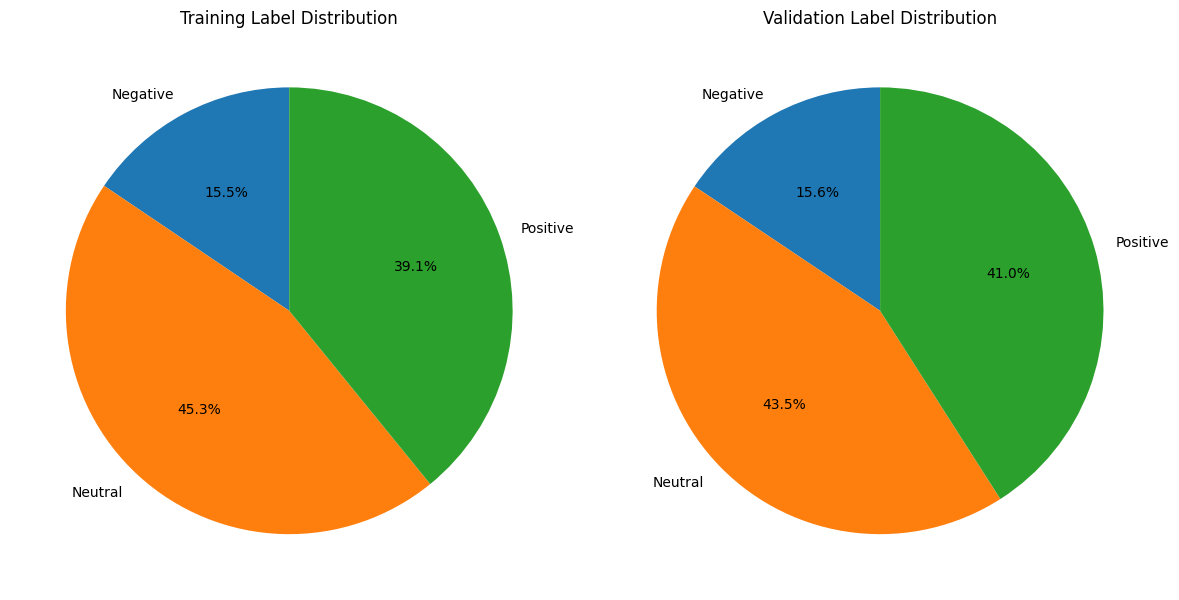

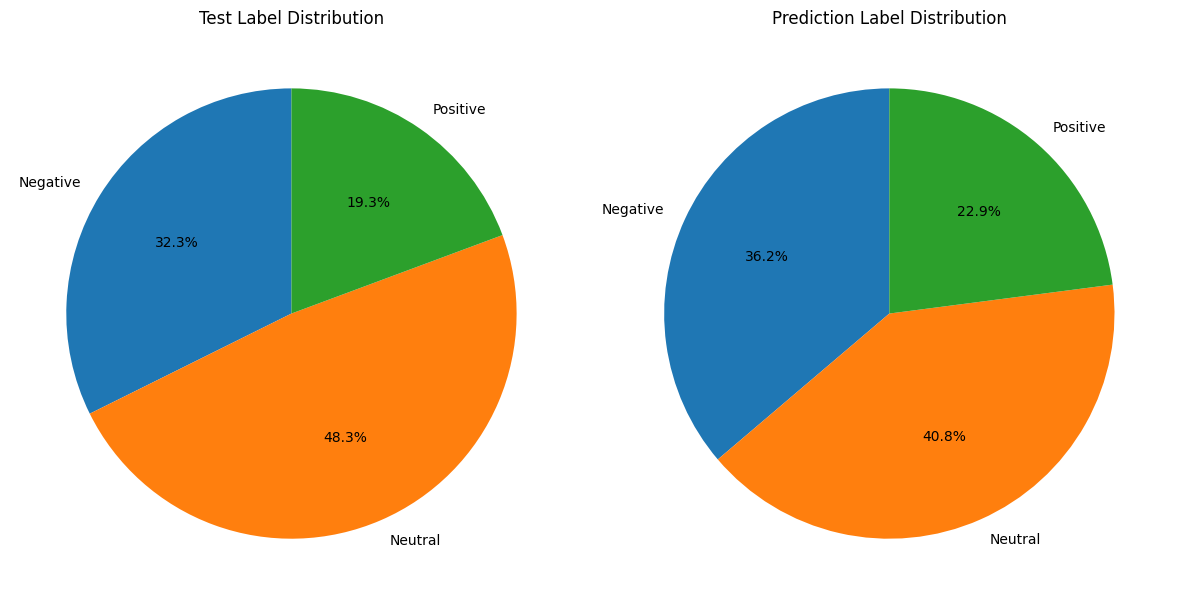

In [15]:

# Label names for the pie chart legends
labels = ['Negative', 'Neutral', 'Positive']
label_counts = [np.bincount(train_label, minlength=3),
                np.bincount(validation_label, minlength=3),
                np.bincount(test_label, minlength=3),
                np.bincount(final_result, minlength=3)]

# First Figure: Training and Validation Set Pie Charts
fig1, ax1 = plt.subplots(1, 2, figsize=(12, 6))

# Training set pie chart
ax1[0].pie(label_counts[0], labels=labels, autopct='%1.1f%%', startangle=90)
ax1[0].set_title('Training Label Distribution')

# Validation set pie chart
ax1[1].pie(label_counts[1], labels=labels, autopct='%1.1f%%', startangle=90)
ax1[1].set_title('Validation Label Distribution')

plt.tight_layout()
plt.show()

# Second Figure: Test Set and Prediction Labels Pie Charts
fig2, ax2 = plt.subplots(1, 2, figsize=(12, 6))

# Test set pie chart
ax2[0].pie(label_counts[2], labels=labels, autopct='%1.1f%%', startangle=90)
ax2[0].set_title('Test Label Distribution')

# Prediction labels pie chart
ax2[1].pie(label_counts[3], labels=labels, autopct='%1.1f%%', startangle=90)
ax2[1].set_title('Prediction Label Distribution')

plt.tight_layout()
plt.show()


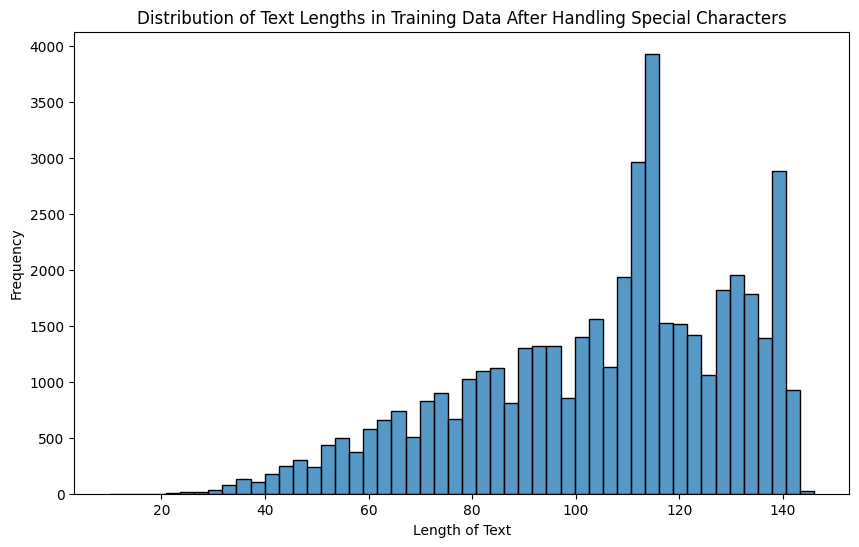

Maximum length: 146


In [16]:
# Histogram of the text lengths
plt.figure(figsize=(10, 6))  
sns.histplot([len(text) for text in train_text], bins=50)
plt.title('Distribution of Text Lengths in Training Data After Handling Special Characters')
plt.xlabel('Length of Text')
plt.ylabel('Frequency')
plt.show()

lengths = [len(text) for text in train_text]
print("Maximum length:", max(lengths))

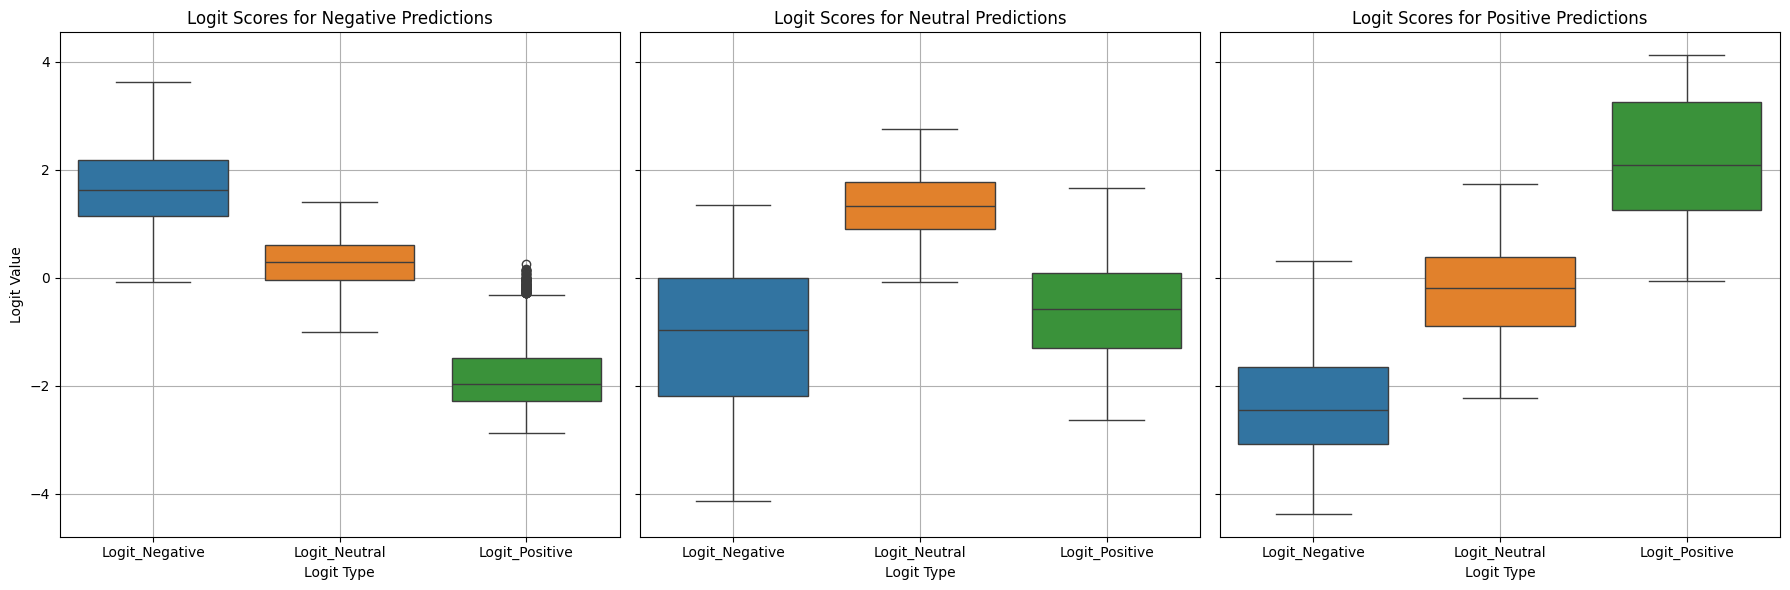

In [17]:
# Compute the predicted labels from logits
predicted_labels = np.argmax(test_prediction.logits, axis=1)

# Create descriptive labels for the predictions
label_names = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
predicted_sentiments = [label_names[label] for label in predicted_labels]

# Creating a DataFrame from logits and adding a column for predicted sentiment labels
logits_df = pd.DataFrame(test_prediction.logits, columns=['Logit_Negative', 'Logit_Neutral', 'Logit_Positive'])
logits_df['Predicted Sentiment'] = predicted_sentiments

# Figure setup
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Plot each logit score within each predicted sentiment category
for i, sentiment in enumerate(['Negative', 'Neutral', 'Positive']):
    # Filter the DataFrame based on predicted sentiment
    filtered_data = logits_df[logits_df['Predicted Sentiment'] == sentiment]

    # Plotting boxplots for each type of logit score within the specific predicted sentiment
    sns.boxplot(data=filtered_data[['Logit_Negative', 'Logit_Neutral', 'Logit_Positive']], ax=axes[i])
    axes[i].set_title(f'Logit Scores for {sentiment} Predictions')
    axes[i].set_xlabel('Logit Type')
    axes[i].set_ylabel('Logit Value')
    axes[i].grid(True)

plt.tight_layout()
plt.show()


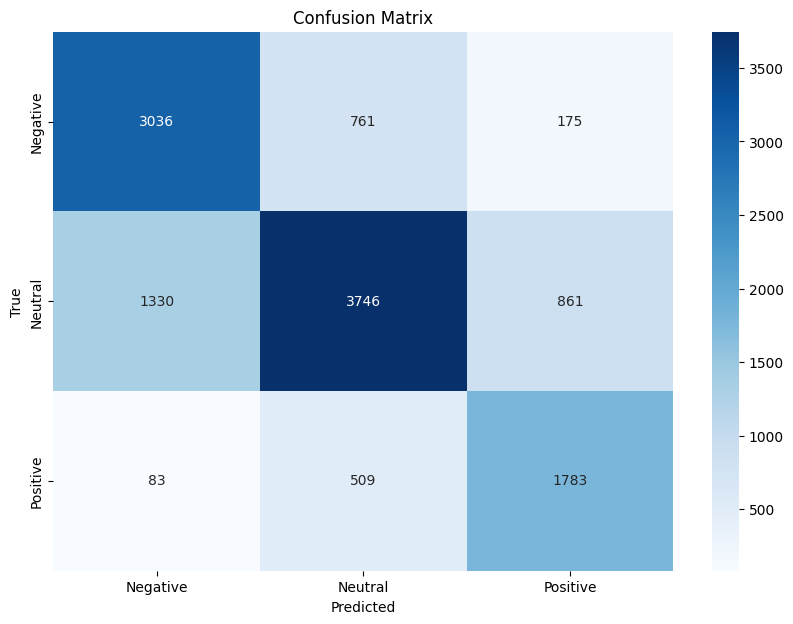

              precision    recall  f1-score   support

    Negative       0.68      0.76      0.72      3972
     Neutral       0.75      0.63      0.68      5937
    Positive       0.63      0.75      0.69      2375

    accuracy                           0.70     12284
   macro avg       0.69      0.72      0.70     12284
weighted avg       0.70      0.70      0.70     12284



In [18]:
# Confusion Matrix
cm = confusion_matrix(test_labels, final_result)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(test_labels, final_result, target_names=['Negative', 'Neutral', 'Positive']))